In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [2]:
# Importing Training Set
dataset_train = pd.read_csv('years1.csv')
print(dataset_train.head())

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6] #toma desde la segunda columna (índice = 1)

# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date']) #lo pasa a lista
datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train] #lo pasa a formato datatime.date

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

         Date  Precio/Litro  Precio  Tem_prom  Litros
0  2019-01-01     10.179487     397      18.9      39
1  2019-01-02     10.193548     316      18.9      31
2  2019-01-03      9.466667     142      18.9      15
3  2019-01-04      9.777778     264      18.9      27
4  2019-01-05      9.916667     119      18.9      12
Training set shape == (1204, 5)
All timestamps == 1204
Featured selected: ['Precio/Litro', 'Precio', 'Tem_prom', 'Litros']


In [3]:
datelist_train

[datetime.date(2019, 1, 1),
 datetime.date(2019, 1, 2),
 datetime.date(2019, 1, 3),
 datetime.date(2019, 1, 4),
 datetime.date(2019, 1, 5),
 datetime.date(2019, 1, 6),
 datetime.date(2019, 1, 7),
 datetime.date(2019, 1, 8),
 datetime.date(2019, 1, 9),
 datetime.date(2019, 1, 10),
 datetime.date(2019, 1, 11),
 datetime.date(2019, 1, 12),
 datetime.date(2019, 1, 13),
 datetime.date(2019, 1, 14),
 datetime.date(2019, 1, 15),
 datetime.date(2019, 1, 16),
 datetime.date(2019, 1, 17),
 datetime.date(2019, 1, 18),
 datetime.date(2019, 1, 19),
 datetime.date(2019, 1, 20),
 datetime.date(2019, 1, 21),
 datetime.date(2019, 1, 22),
 datetime.date(2019, 1, 23),
 datetime.date(2019, 1, 24),
 datetime.date(2019, 1, 25),
 datetime.date(2019, 1, 26),
 datetime.date(2019, 1, 27),
 datetime.date(2019, 1, 28),
 datetime.date(2019, 1, 29),
 datetime.date(2019, 1, 30),
 datetime.date(2019, 1, 31),
 datetime.date(2019, 2, 1),
 datetime.date(2019, 2, 2),
 datetime.date(2019, 2, 3),
 datetime.date(2019, 2, 4)

In [4]:
dataset_train = dataset_train[cols].astype(str)

for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float) #hacerlo todo floats

# Using multiple features (predictors)
training_set = dataset_train.values #hace un array con los valores de las columnas

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (1204, 4).


array([[ 10.17948718, 397.        ,  18.9       ,  39.        ],
       [ 10.19354839, 316.        ,  18.9       ,  31.        ],
       [  9.46666667, 142.        ,  18.9       ,  15.        ],
       ...,
       [ 14.61111111, 263.        ,  25.        ,  18.        ],
       [ 14.51724138, 421.        ,  25.        ,  29.        ],
       [ 14.57142857, 102.        ,  25.        ,   7.        ]])

In [5]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[ 0.0284994 ],
       [ 0.03508984],
       [-0.30559686],
       ...,
       [ 2.10558465],
       [ 2.06158826],
       [ 2.08698559]])

In [47]:
# Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 60   # Number of days we want top predict into the future
n_past = 90     # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (1055, 90, 3).
y_train shape == (1055, 1).


In [6]:
2.6/0.11

23.636363636363637

In [48]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam

In [49]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=10, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.25))

# Output layer
model.add(Dense(units=1, activation='linear'))

# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')

In [50]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=30, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=256)

Epoch 1/30
4/4 [==============================] - ETA: 0s - loss: 0.3785
Epoch 1: val_loss improved from inf to 0.79091, saving model to weights.h5
4/4 [==============================] - 5s 465ms/step - loss: 0.3785 - val_loss: 0.7909 - lr: 0.0100
Epoch 2/30
4/4 [==============================] - ETA: 0s - loss: 0.2015
Epoch 2: val_loss did not improve from 0.79091
4/4 [==============================] - 1s 198ms/step - loss: 0.2015 - val_loss: 1.2052 - lr: 0.0100
Epoch 3/30
4/4 [==============================] - ETA: 0s - loss: 0.1750
Epoch 3: val_loss did not improve from 0.79091
4/4 [==============================] - 1s 236ms/step - loss: 0.1750 - val_loss: 1.8795 - lr: 0.0100
Epoch 4/30
4/4 [==============================] - ETA: 0s - loss: 0.1878
Epoch 4: val_loss did not improve from 0.79091
4/4 [==============================] - 1s 197ms/step - loss: 0.1878 - val_loss: 1.4839 - lr: 0.0100
Epoch 5/30
4/4 [==============================] - ETA: 0s - loss: 0.1696
Epoch 5: val_loss d

In [58]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist() #crea lista de los siguientes días, indicado anteriormente
#print(datelist_future)

'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

#print(datelist_future_)

In [59]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])

predictions_train = model.predict(X_train[n_past:])

31/31 [==============================] - 1s 17ms/step


In [64]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Precio/Litro']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Precio/Litro']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN

,Precio/Litro
2019-08-28,7.969130
2019-08-29,7.958794
2019-08-30,7.974874
2019-08-31,7.997645
2019-09-01,8.010054
...,...
2022-04-14,11.149485
2022-04-15,11.160851
2022-04-16,11.279573
2022-04-17,11.361197


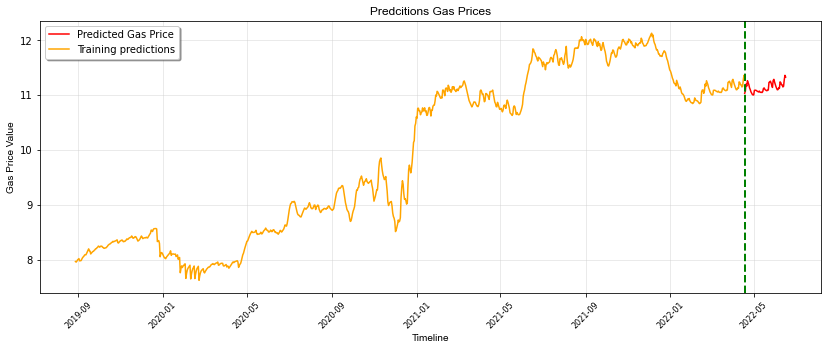

In [65]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2019'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Precio/Litro'], color='r', label='Predicted Gas Price')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Precio/Litro'], color='orange', label='Training predictions')
#plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Precio/Litro'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions Gas Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Gas Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()

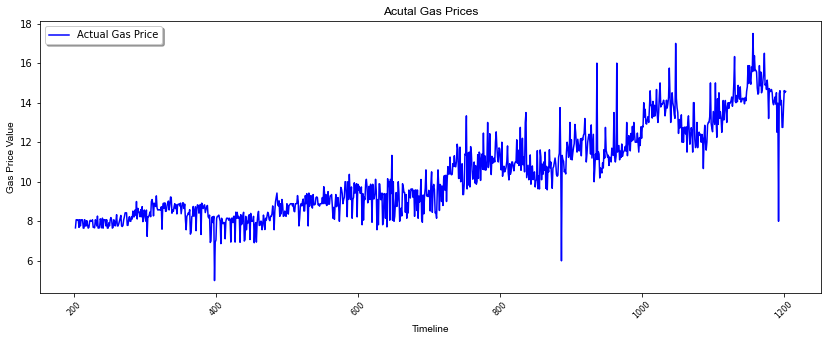

In [13]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2019'


plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Precio/Litro'], color='b', label='Actual Gas Price')



plt.legend(shadow=True)
plt.title('Acutal Gas Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Gas Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()